Welcome to JupyROOT 6.28/10
Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-006-000.001939_000.root
Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-006-000.001940_000.root
Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-006-000.001941_000.root
Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-006-000.001942_000.root
Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-006-000.001943_000.root
Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-006-000.001944_000.root
Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-006-000.001945_000.root
Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-006-000.001946_000.root
Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-006-000.001947_000.root
Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-006-000.001948_000.root
Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-006-000.001949_000.root
Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-006-000.001950_000.root
Reading file: rec.mu2e.CRV_wideband_

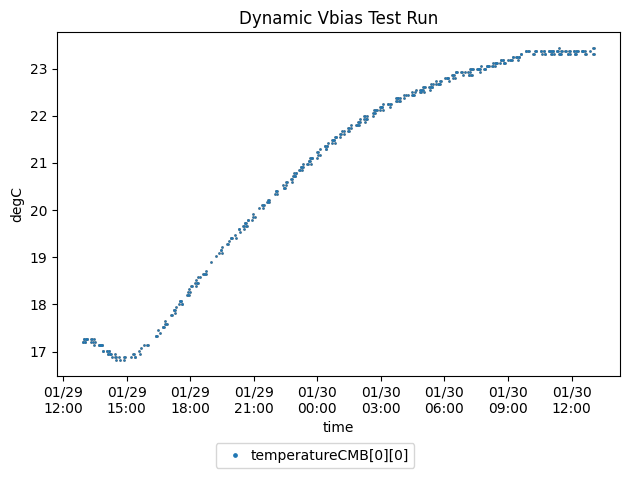

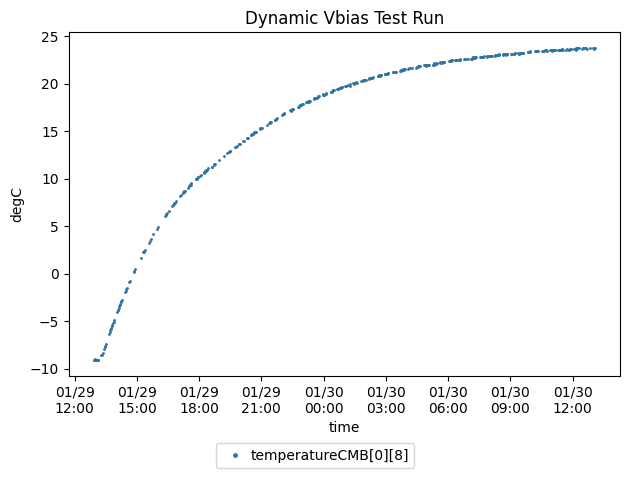

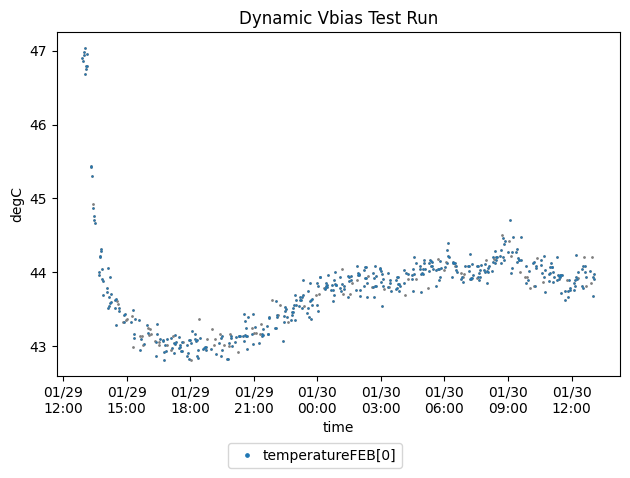

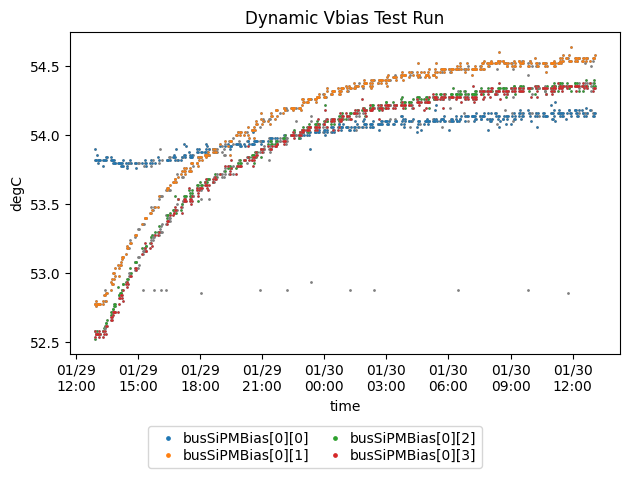

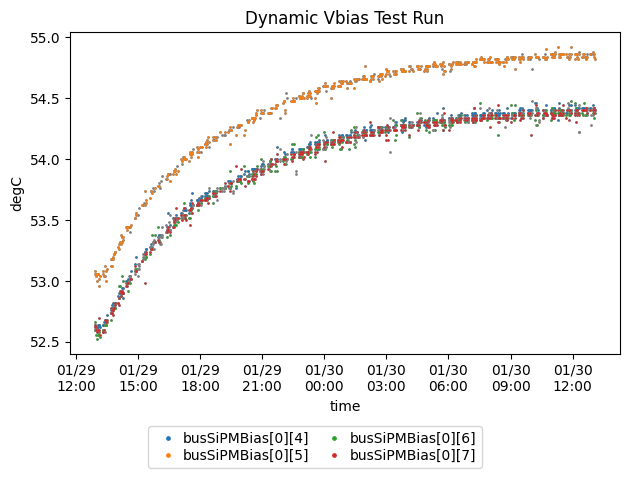

In [1]:
from __future__ import print_function
import sys, os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import ROOT
from ROOT import gROOT, gStyle, gDirectory, gPad

from array import array
import tarfile
import subprocess

import constants
import crv_event
import crv_spill
import utils
import geometry
import geometry_constants
import filepath

gROOT.Reset()
gROOT.SetBatch(1)
gROOT.ProcessLine( "gErrorIgnoreLevel = 1001;")
gStyle.SetOptStat(111110)
gStyle.SetOptFit(0)
gStyle.SetLineScalePS(0.3)

topdir = os.path.dirname(os.path.abspath("__file__"))
settings_dir = os.path.join(topdir,"settings")

filelist = filepath.getfilelist(["SiDet2DynamicVbias"],"recoROOT",6)[0]
tarname = "raw.mu2e.CRV_wideband_cosmics.crvled-004.001939-002002_settings_history.tar.gz"
tarname = os.path.join(settings_dir,tarname)
logname_list = tarfile.open(tarname).getnames()

nSmooth = 1 
tdict = {'*':[["temperatureCMB[0][0]"],  
              ["temperatureCMB[0][8]"],  
              ["temperatureFEB[0]"],
              ["busSiPMBias[0][0:4]"],
              ["busSiPMBias[0][4:8]"]]}

tfig = utils.plot_dqm(filelist, tdict, '& 0xfffffffffffffe == 0x0', False, nSmooth, True, "Dynamic Vbias Test Run;time;degC")

In [2]:
import pandas as pd
from scipy import stats
import settings_FEB

def ParseLog(tarname, filename, nFEB):
    df = pd.DataFrame()
    settingsReference = [None]*nFEB

    fFile = ROOT.TFile(filename, "READ")
    spilltree = fFile.Get("spills")
    nSpill = spilltree.GetEntries()
    nSkippedSpillIndex = 0
    iSpill = 0

    runNum = filepath.filenameparser(filename, 'run')
    logname = "settings_log/raw.mu2e.CRV_wideband_cosmics.crvled-004.%06i_settings_history.log" % runNum
    
    with tarfile.open(tarname, 'r:gz') as tar:
        selected_member = None
        for member in tar.getmembers():
            if member.name == logname:
                selected_member = member
                break
        if selected_member is None:
            print("Cannot find %s in the tarball"%logname)
            return None
        else:
            fin = tar.extractfile(logname)
            data = fin.read().decode()
            data = data.replace("##", "*")
            data = data.replace("# FEB Temp.:", "# FEBTemp.:")
            data = data.split("# Spill ")
    
            referenceBlock = data[0]
            data = data[1:]
    
            referenceBlock = referenceBlock.split("--- FEB ")[1:]
            for iFEB in range(nFEB):
                FEBBlock = referenceBlock[iFEB].split("\n")
                settingsReference[iFEB] = settings_FEB.settingsFEB(FEBBlock[4], " ".join(FEBBlock[6:10]), FEBBlock[11], None, None, 25.0, 40.0)
                
            for index, block in enumerate(data):
                fields = block.split("# FEB ")
                #print(fields)
    
                logSpillNum = int(fields[0].split()[0])
                #print(logSpillNum)
    
                tSpill = crv_spill.crv_spill(spilltree, iSpill)
                if logSpillNum != tSpill.spillNumber-1:
                    tSpill = None
                        
                for iFEB in range(nFEB):
                    df_ = pd.DataFrame()
                    FEBBlock = fields[iFEB+1].split("\n")
                    #print(FEBBlock)
                    df_['runNum'] = [runNum]
                    df_['timestamp'] = [0 if tSpill is None else tSpill.tsEpoch]
                    df_['spillNum'] = [logSpillNum]
                    df_['FEB'] = [int(FEBBlock[0].split(":")[0])]
    
                    thisCMBTempStr = FEBBlock[2]
                    thisFEBTempStr = FEBBlock[3]
    
                    # NorminalSettings = settingsReference[iFEB].AdjustBulkByTemp(thisCMBTempStr, thisFEBTempStr)
                    NorminalSettings = settingsReference[iFEB].AdjustBulkByTemp_SiDetRun2(thisCMBTempStr, thisFEBTempStr)
                    for i in range(8):
                        df_['bulkNominal%i'%i] = [NorminalSettings.bulks[i]]

                    df_['CMBTemp0Input'] = [float(thisCMBTempStr.split()[0])]
    
                    AppliedSettings = settings_FEB.settingsFEB(FEBBlock[9], " ".join(FEBBlock[11:15]), FEBBlock[16], thisCMBTempStr, thisFEBTempStr)
                    for i in range(8):
                        df_['bulkSettings%i'%i] = [AppliedSettings.bulks[i]]
    
                    readBackmV = FEBBlock[19].split()
                    for i in range(8):
                        df_['readBackVAtSetup%i'%i] = [float(readBackmV[i])/21.*20.]
                        df_['readBackVAtSpill%i'%i] = [0. if tSpill is None else tSpill.busSiPMBias[iFEB][i]]
                        # df_['readBackVAtSpill%i'%i] = [0. if tSpill is None else tSpill.bulkBiasRdbk[iFEB][i*8]]

                    df_['CMBTemp0Rdbk'] = [0. if tSpill is None else tSpill.temperatureCMB[iFEB][0]]
    
                    df_['goodFEBTemp'] = [True if (float(thisFEBTempStr)<60 and float(thisFEBTempStr)!=-999.) else False]
                    df_['goodReadbk'] = [False if FEBBlock[19] == "0 0 0 0 0 0 0 0 " else True]
                    df_['goodRdbkSpill'] = [False if (tSpill is None or np.any(tSpill.busSiPMBias[iFEB]<1)) else True]
    
                    df = pd.concat([df,df_], ignore_index=True)

                if tSpill != None:
                    iSpill += 1

    fFile.Close()
    return df

df = pd.DataFrame()
for filename in filelist:
    df_ = ParseLog(tarname, filename, 1)
    df = pd.concat([df,df_], ignore_index=True)

display(df)

,runNum,timestamp,spillNum,FEB,bulkNominal0,bulkNominal1,bulkNominal2,bulkNominal3,bulkNominal4,bulkNominal5,...,readBackVAtSetup5,readBackVAtSpill5,readBackVAtSetup6,readBackVAtSpill6,readBackVAtSetup7,readBackVAtSpill7,CMBTemp0Rdbk,goodFEBTemp,goodReadbk,goodRdbkSpill
0,1939,1706554496,0,0,2703.013125,2630.820000,2630.906562,2631.166250,2630.646875,2630.733438,...,55.047619,53.08,54.561905,52.60,54.580952,52.62,17.0625,True,True,True
1,1939,1706554587,1,0,2703.013125,2630.993125,2631.079688,2631.166250,2630.560312,2630.646875,...,53.161905,53.06,52.561905,52.66,52.723810,52.64,17.0625,True,True,True
2,1939,1706554678,2,0,2703.013125,2630.820000,2630.993125,2631.166250,2630.560312,2630.733438,...,53.161905,53.04,52.676190,52.60,52.723810,52.60,17.1250,True,True,True
3,1939,1706554769,3,0,2703.186250,2630.820000,2630.993125,2631.166250,2630.646875,2630.733438,...,53.123810,53.06,52.657143,52.56,52.704762,52.62,17.1250,True,True,True
4,1939,1706554861,4,0,2703.186250,2630.993125,2631.166250,2631.166250,2630.646875,2630.646875,...,53.142857,53.00,52.676190,52.52,52.704762,52.58,17.0625,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699,2002,1706641218,6,0,2719.979375,2721.018125,2721.277812,2721.104688,2721.018125,2721.191250,...,54.961905,54.88,54.485714,54.38,54.504762,54.40,23.1250,True,True,True
700,2002,1706641309,7,0,2719.806250,2720.931562,2721.191250,2721.104688,2721.018125,2721.191250,...,54.942857,54.84,54.523810,54.38,54.504762,54.42,23.2500,True,True,True
701,2002,1706641400,8,0,2720.152500,2721.104688,2721.191250,2721.104688,2721.018125,2721.191250,...,54.961905,54.86,54.485714,54.34,54.485714,54.38,23.1250,True,True,True
702,2002,1706641491,9,0,2719.806250,2720.845000,2721.104688,2721.104688,2721.018125,2721.191250,...,54.980952,54.82,54.485714,54.38,54.485714,54.40,23.2500,True,True,True


In [3]:
df_ = df.query("goodFEBTemp==False | goodReadbk==False").reset_index()
display(df_)

,index,runNum,timestamp,spillNum,FEB,bulkNominal0,bulkNominal1,bulkNominal2,bulkNominal3,bulkNominal4,...,readBackVAtSetup5,readBackVAtSpill5,readBackVAtSetup6,readBackVAtSpill6,readBackVAtSetup7,readBackVAtSpill7,CMBTemp0Rdbk,goodFEBTemp,goodReadbk,goodRdbkSpill


In [4]:
df_ = df.query("goodRdbkSpill==False").reset_index()
display(df_)

,index,runNum,timestamp,spillNum,FEB,bulkNominal0,bulkNominal1,bulkNominal2,bulkNominal3,bulkNominal4,...,readBackVAtSetup5,readBackVAtSpill5,readBackVAtSetup6,readBackVAtSpill6,readBackVAtSetup7,readBackVAtSpill7,CMBTemp0Rdbk,goodFEBTemp,goodReadbk,goodRdbkSpill
0,10,1939,0,10,0,2703.186250,2630.906562,2631.079688,2631.252812,2630.646875,...,53.161905,0.0,52.657143,0.0,52.657143,0.0,0.0,True,True,False
1,14,1940,0,3,0,2703.186250,2632.984063,2632.984063,2633.243750,2632.724375,...,53.200000,0.0,52.742857,0.0,52.704762,0.0,0.0,True,True,False
2,20,1940,0,9,0,2703.013125,2635.580937,2635.407813,2635.494375,2634.975000,...,53.200000,0.0,52.761905,0.0,52.780952,0.0,0.0,True,True,False
3,21,1940,0,10,0,2655.750000,2635.840625,2635.667500,2636.013750,2635.407813,...,53.238095,0.0,52.780952,0.0,52.780952,0.0,0.0,True,True,False
4,32,1941,0,10,0,2702.493750,2642.505938,2642.419375,2642.246250,2641.640313,...,53.342857,0.0,52.904762,0.0,52.923810,0.0,0.0,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,692,2001,0,10,0,2719.806250,2720.758438,2721.018125,2721.018125,2720.931562,...,55.028571,0.0,54.504762,0.0,54.485714,0.0,0.0,True,True,False
173,694,2002,0,1,0,2719.979375,2720.931562,2721.104688,2721.018125,2720.845000,...,54.961905,0.0,54.485714,0.0,54.504762,0.0,0.0,True,True,False
174,696,2002,0,3,0,2719.806250,2720.758438,2721.018125,2721.018125,2721.018125,...,54.961905,0.0,54.485714,0.0,54.485714,0.0,0.0,True,True,False
175,697,2002,0,4,0,2720.152500,2721.104688,2721.191250,2721.104688,2720.931562,...,54.980952,0.0,54.485714,0.0,54.504762,0.0,0.0,True,True,False


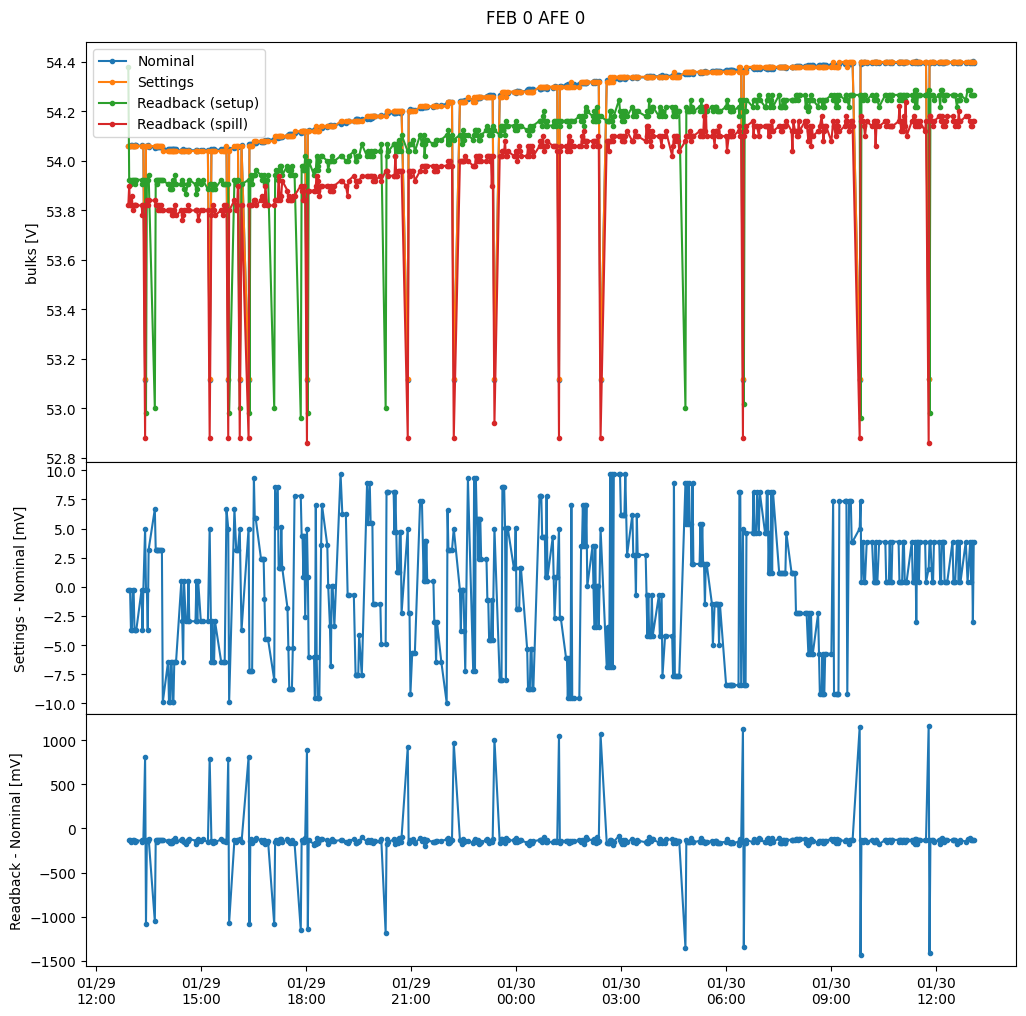

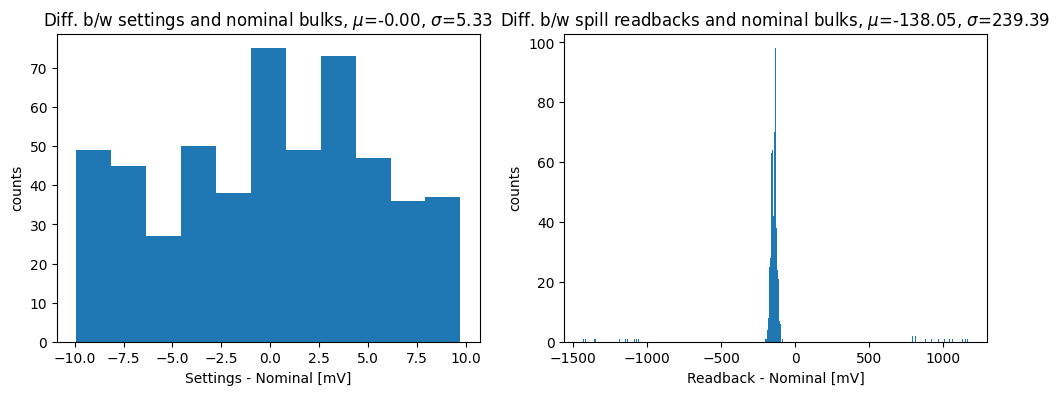

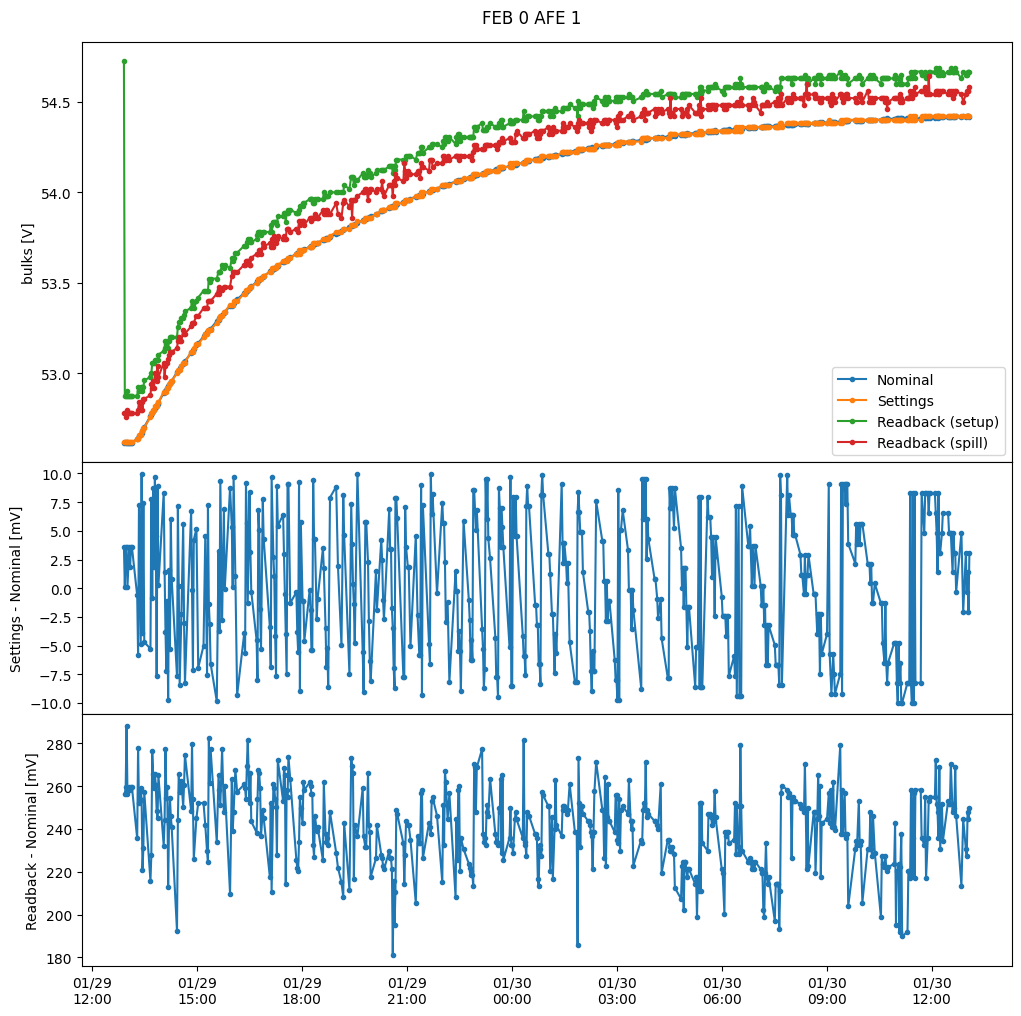

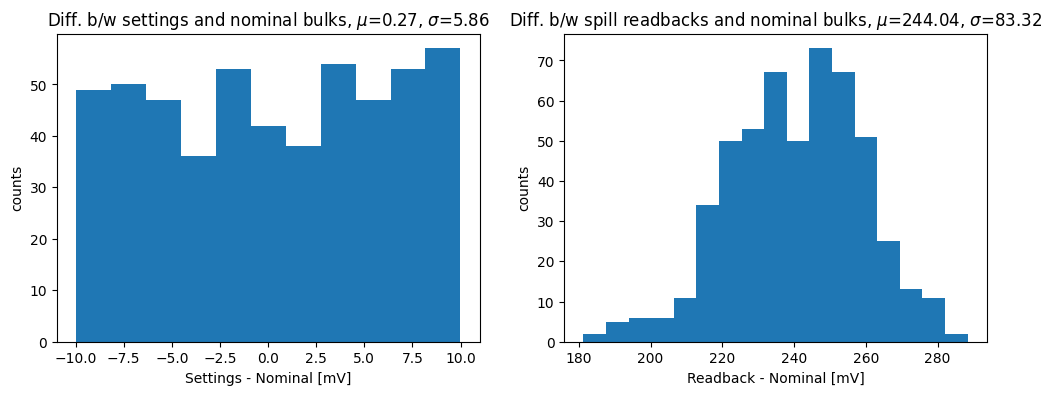

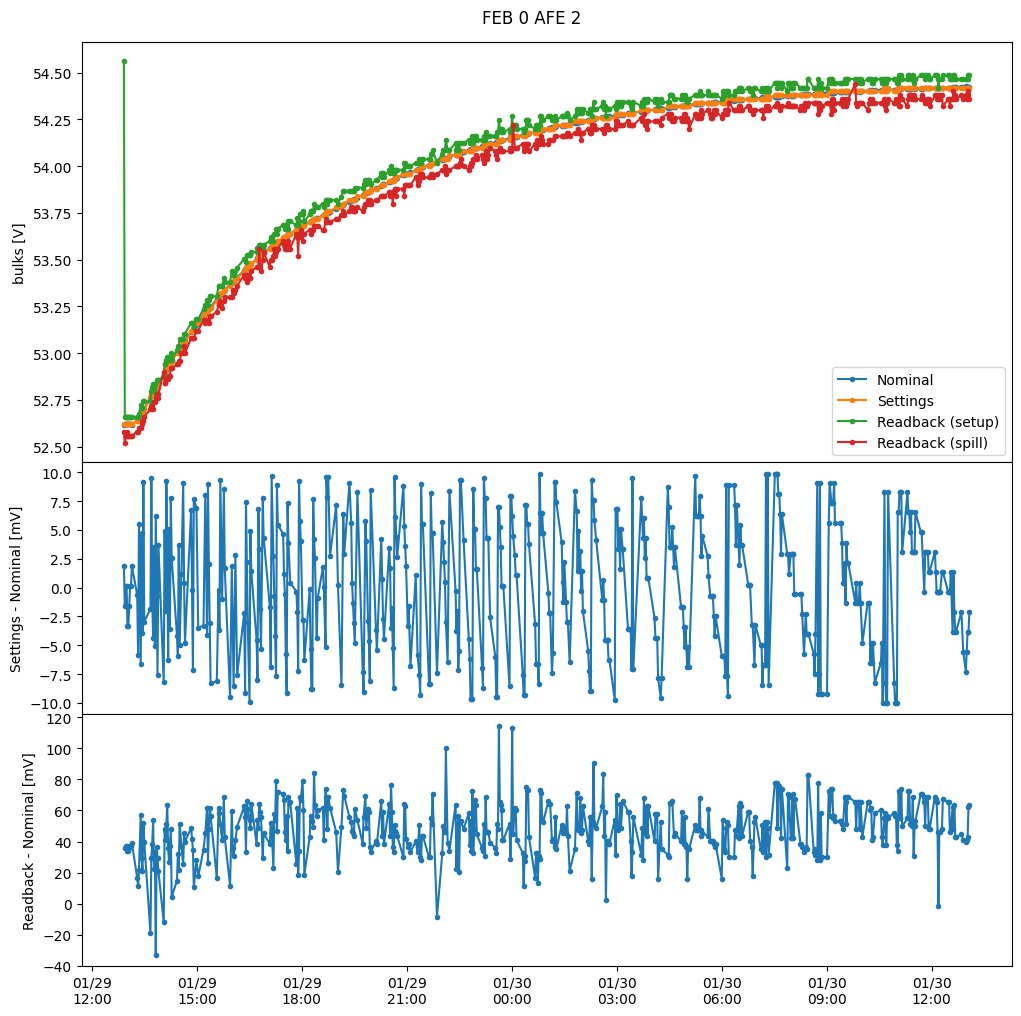

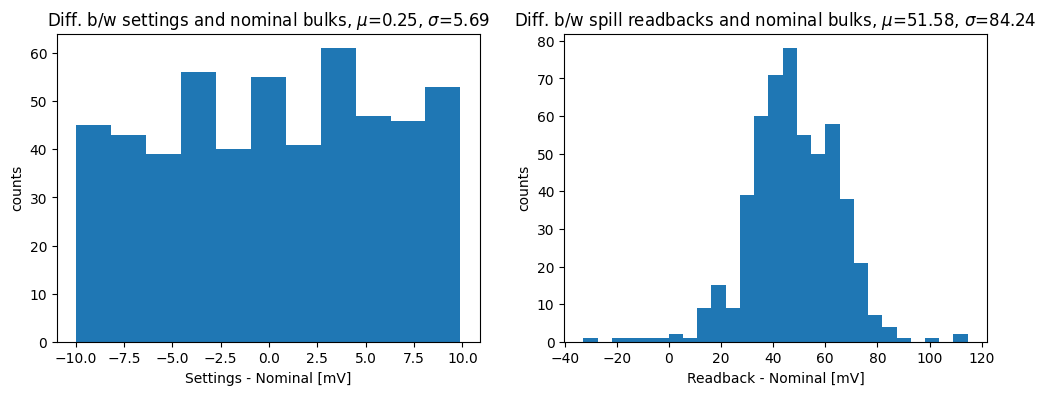

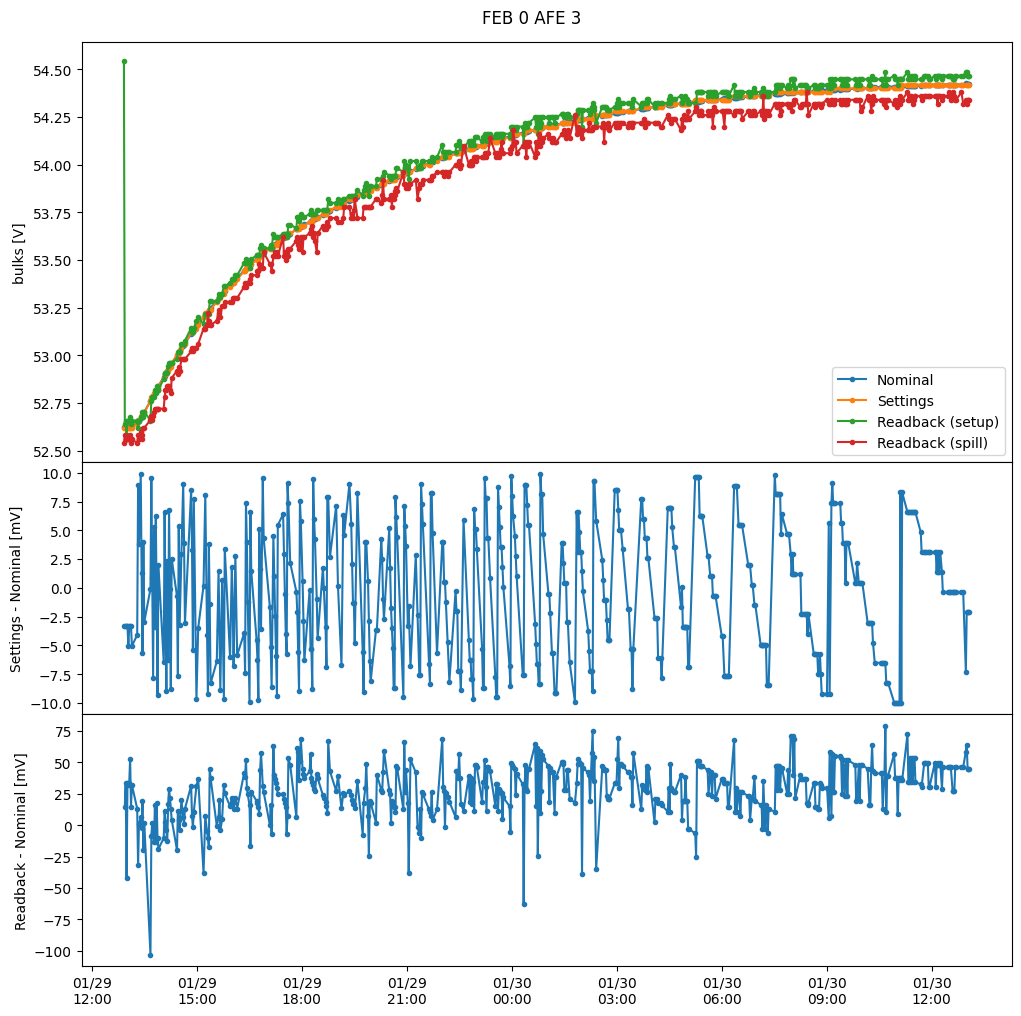

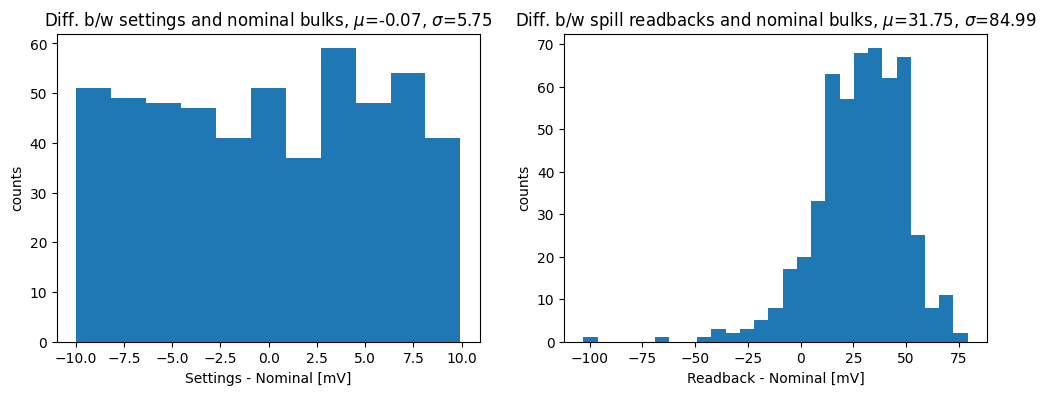

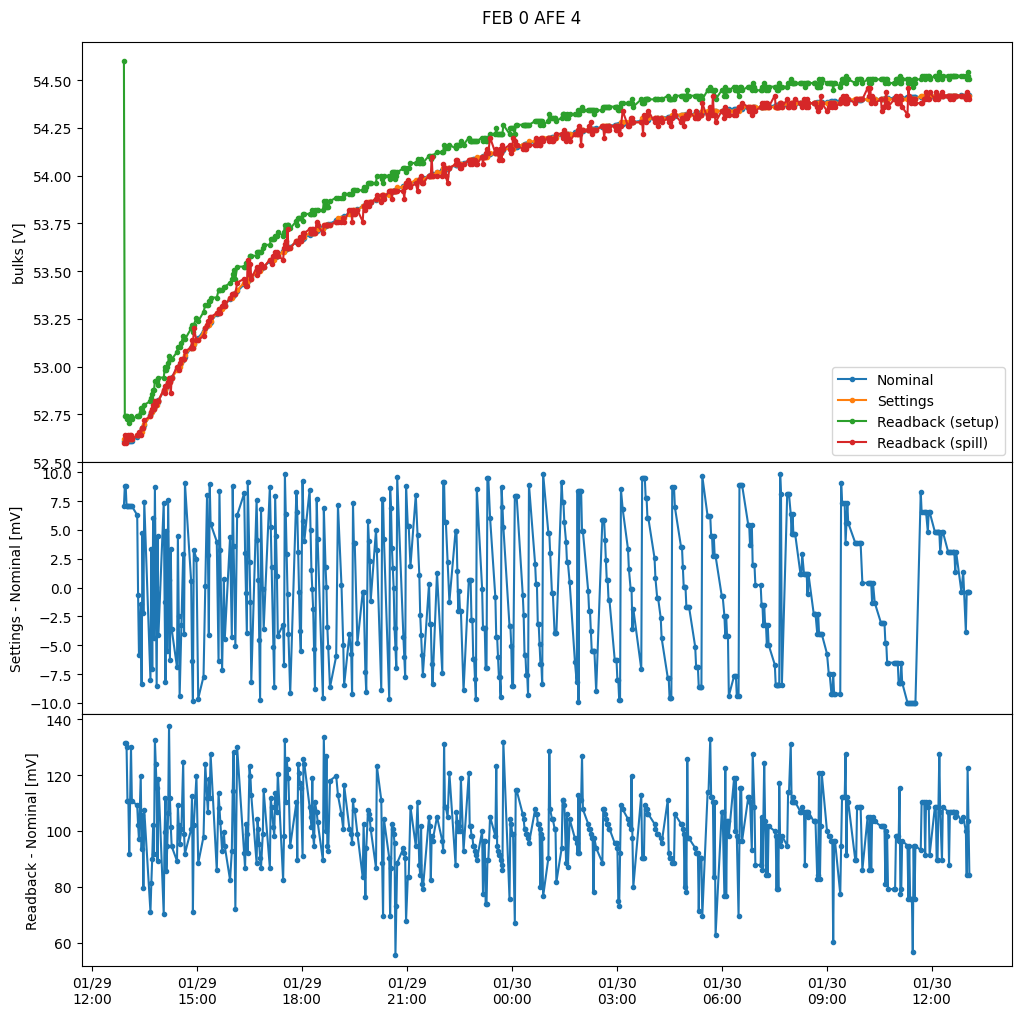

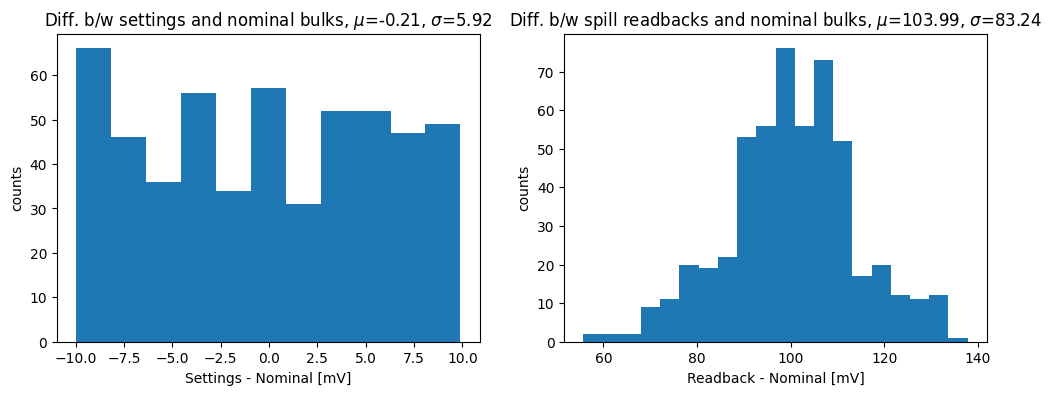

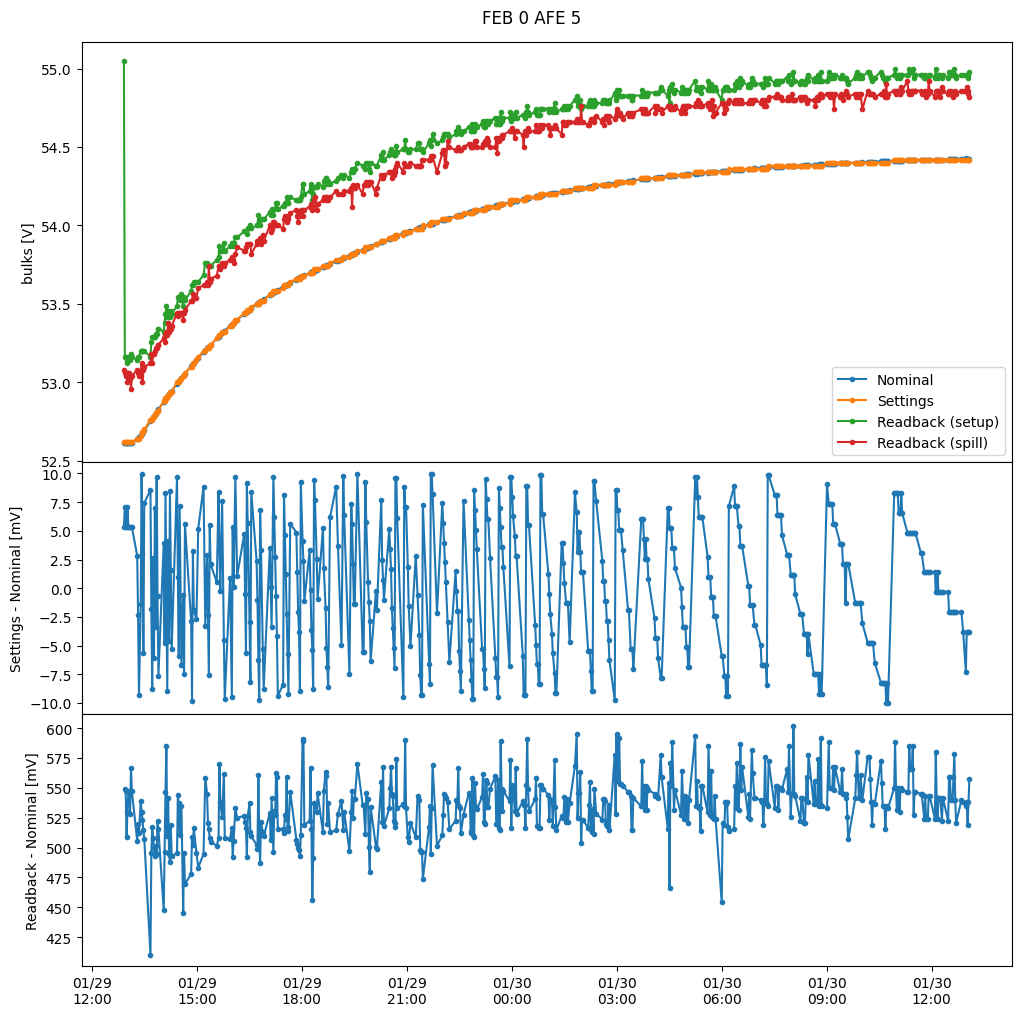

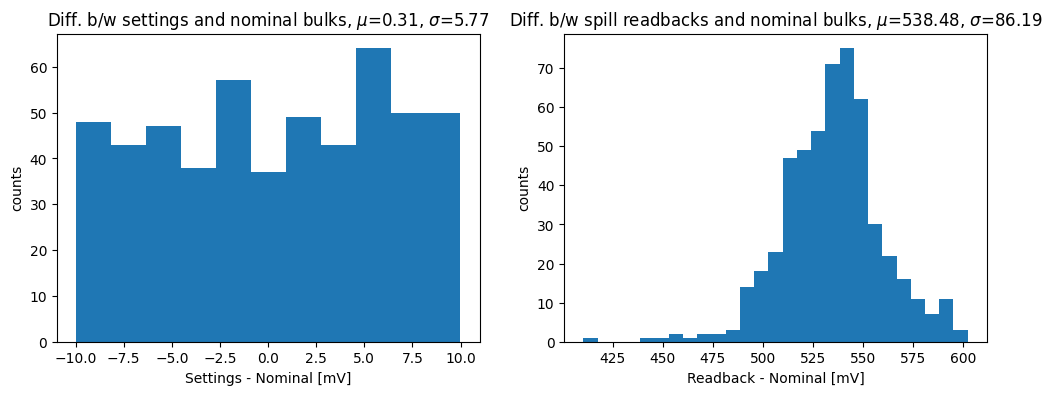

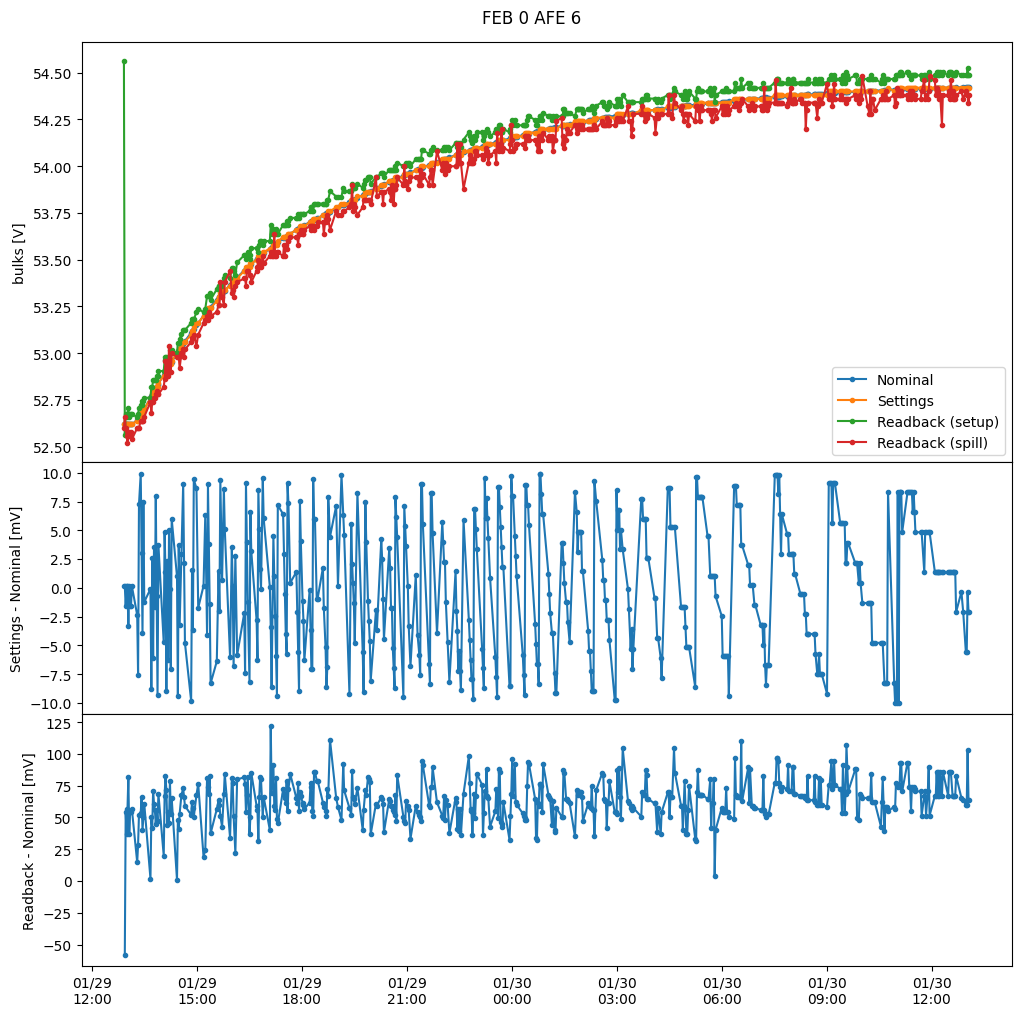

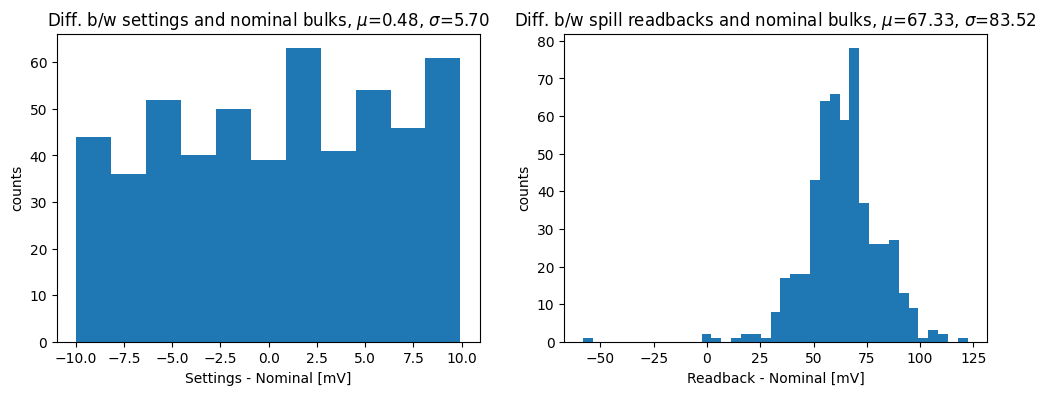

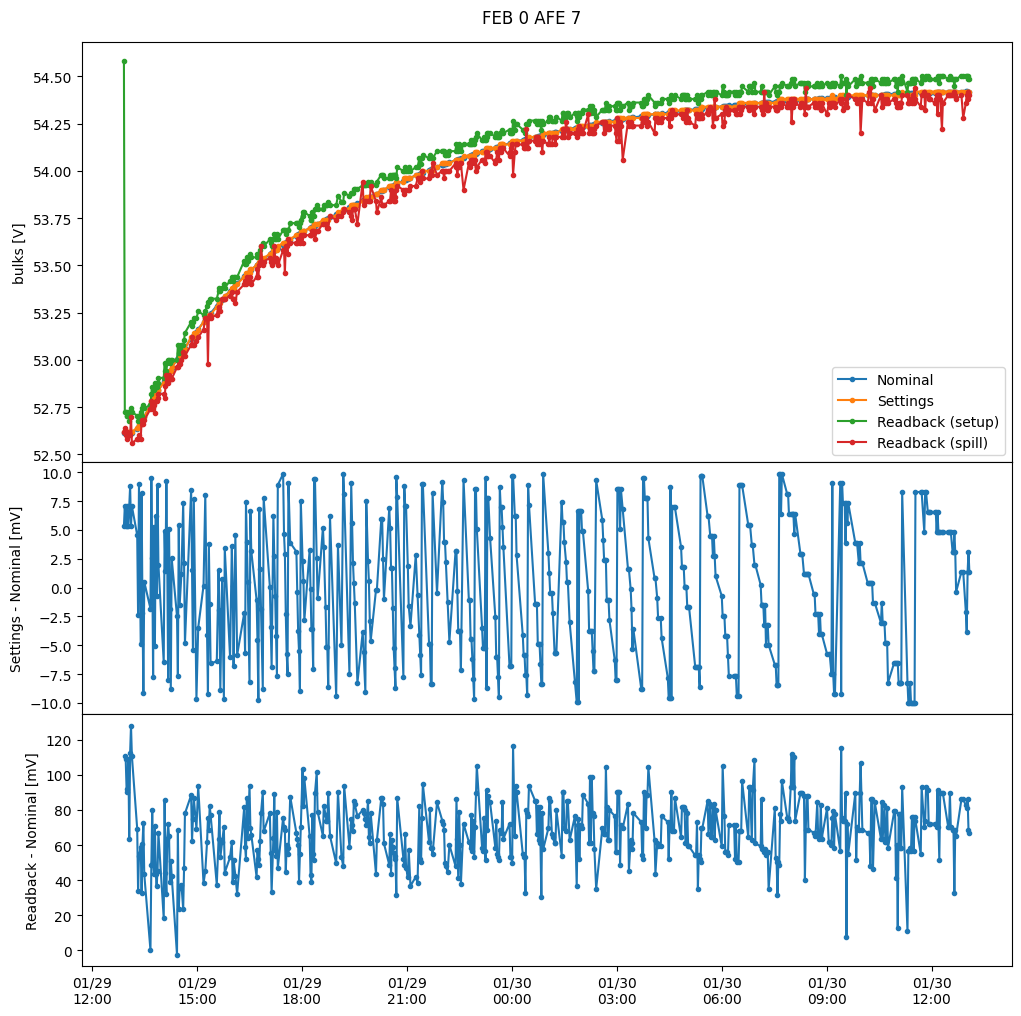

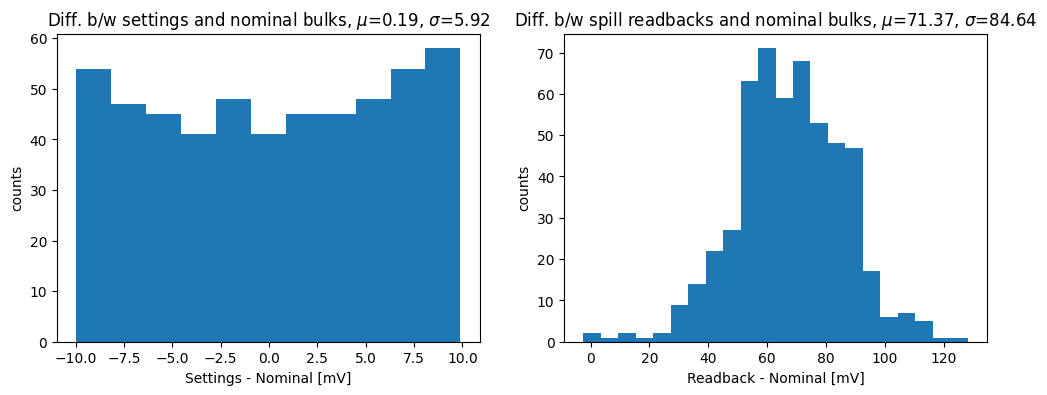

In [5]:
from matplotlib.dates import DateFormatter

for iFEB in range(1):
    df_ = df.query("FEB==%i & goodFEBTemp==True & goodReadbk==True & goodRdbkSpill==True"%iFEB).reset_index()
    # display(df_)
    for iAFE in range(8):
        fig = plt.figure(figsize = (12,11))
        fig.subplots_adjust(top=0.95)
        plt.suptitle('FEB %i AFE %i'%(iFEB, iAFE))
        axs = fig.subplots(3, 1, sharex='col',
                           gridspec_kw={'height_ratios':[5,3,3],
                                        'wspace':0, 'hspace':0})

        ytitles = ['bulks [V]', 'Settings - Nominal [mV]', 'Readback - Nominal [mV]']
        for ii in range(3):
            axs[ii].set_ylabel(ytitles[ii])
        axs[2].set_xlabel('')

        axs[0].plot_date(utils.ts2datetime(df_['timestamp']), df_['bulkNominal%i'%iAFE]*0.02, '.-', label=('Nominal'))
        axs[0].plot_date(utils.ts2datetime(df_['timestamp']), df_['bulkSettings%i'%iAFE]*0.02, '.-', label=('Settings'))
        axs[0].plot_date(utils.ts2datetime(df_['timestamp']), df_['readBackVAtSetup%i'%iAFE], '.-', label=('Readback (setup)'))
        axs[0].plot_date(utils.ts2datetime(df_['timestamp']), df_['readBackVAtSpill%i'%iAFE], '.-', label=('Readback (spill)'))
        axs[0].legend()

        diffSettingNom = np.subtract(df_['bulkSettings%i'%iAFE]*20 ,df_['bulkNominal%i'%iAFE]*20)
        axs[1].plot_date(utils.ts2datetime(df_['timestamp']), diffSettingNom, '.-')
        diffReadbkNom = np.subtract(df_['readBackVAtSetup%i'%iAFE]*1000 ,df_['bulkNominal%i'%iAFE]*20)
        axs[2].plot_date(utils.ts2datetime(df_['timestamp'][1:]), diffReadbkNom[1:], '.-')
        
        formatter = DateFormatter('%m/%d\n%H:%M')
        plt.gca().xaxis.set_major_formatter(formatter)
        plt.show()
        plt.close(fig)
        
        fig, axs = plt.subplots(1,2,figsize=(12,4))
        axs[0].hist(diffSettingNom[1:], bins='auto')
        axs[0].set_title("Diff. b/w settings and nominal bulks, "+r'$\mu$'+"=%.2f"%(np.mean(diffSettingNom))+r', $\sigma$'+"=%.2f"%(np.std(diffSettingNom)))
        axs[0].set_xlabel(ytitles[1])
        axs[0].set_ylabel("counts")
        axs[1].hist(diffReadbkNom[1:], bins='auto')
        axs[1].set_title("Diff. b/w spill readbacks and nominal bulks, "+r'$\mu$'+"=%.2f"%(np.mean(diffReadbkNom))+r', $\sigma$'+"=%.2f"%(np.std(diffReadbkNom)))
        axs[1].set_xlabel(ytitles[2])
        axs[1].set_ylabel("counts")
        plt.show()
        plt.close(fig)
        

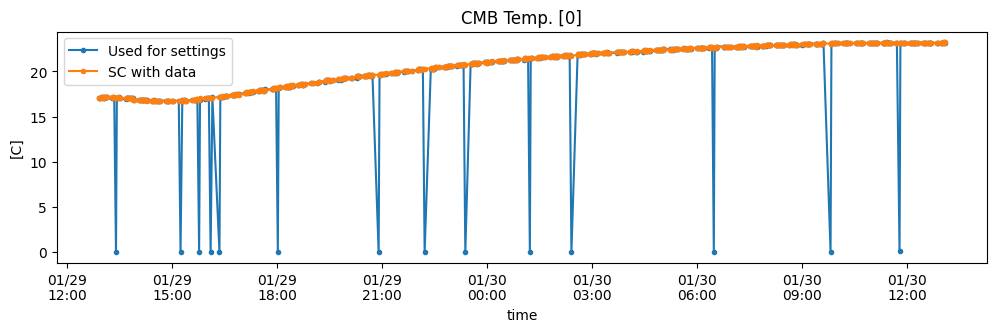

In [6]:
df_ = df.query("FEB==0 & goodFEBTemp==True & goodReadbk==True & goodRdbkSpill==True").reset_index()
fig = plt.figure(figsize = (12,3))
plt.title("CMB Temp. [0]")
plt.plot_date(utils.ts2datetime(df_['timestamp']), df_['CMBTemp0Input'], '.-', label=('Used for settings'))
plt.plot_date(utils.ts2datetime(df_['timestamp']), df_['CMBTemp0Rdbk'], '.-', label=('SC with data'))
plt.xlabel("time")
plt.ylabel("[C]")
formatter = DateFormatter('%m/%d\n%H:%M')
plt.gca().xaxis.set_major_formatter(formatter)
plt.legend()
plt.show()
        

Safety check for 0 degC was removed to accomodate < 0 degC temperatures. Only occuring with CMB0 may indicate not enough time to read back.
Readback at setup needs time to converge (coming from "adc0", from previous spills). 

In [7]:
df_badsetting = df.query("FEB==0 & goodFEBTemp==True & goodReadbk==True & goodRdbkSpill==True & CMBTemp0Input<3").reset_index()
display(df_badsetting)
print(df_badsetting['CMBTemp0Input'])

,index,runNum,timestamp,spillNum,FEB,bulkNominal0,bulkNominal1,bulkNominal2,bulkNominal3,bulkNominal4,...,readBackVAtSetup5,readBackVAtSpill5,readBackVAtSetup6,readBackVAtSpill6,readBackVAtSetup7,readBackVAtSpill7,CMBTemp0Rdbk,goodFEBTemp,goodReadbk,goodRdbkSpill
0,15,1940,1706556225,4,0,2655.750000,2633.243750,2633.330313,2633.503438,2633.070625,...,53.200000,53.04,52.723810,52.64,52.723810,52.58,17.0625,True,True,True
1,68,1945,1706562868,2,0,2655.750000,2660.770625,2660.597500,2660.597500,2659.991562,...,53.761905,53.62,53.238095,53.18,53.257143,53.22,16.7500,True,True,True
2,85,1946,1706564780,8,0,2655.750000,2666.656875,2666.570312,2666.483750,2665.964375,...,53.885714,53.74,53.400000,53.26,53.400000,53.32,16.8750,True,True,True
3,94,1947,1706565963,6,0,2655.750000,2669.946250,2669.859687,2669.859687,2669.253750,...,53.923810,53.82,53.419048,53.36,53.438095,53.30,17.0625,True,True,True
4,100,1948,1706566873,1,0,2655.750000,2672.196875,2672.110312,2672.196875,2671.590938,...,53.961905,53.84,53.523810,53.40,53.523810,53.40,17.1875,True,True,True
5,150,1952,1706572879,7,0,2655.750000,2684.055937,2684.142500,2683.969375,2683.536562,...,54.266667,54.06,53.742857,53.64,53.780952,53.62,18.1250,True,True,True
6,232,1960,1706583252,1,0,2655.750000,2697.386562,2697.559688,2697.473125,2697.213438,...,54.485714,54.34,54.000000,53.90,54.000000,53.90,19.6250,True,True,True
7,272,1963,1706587985,8,0,2655.750000,2702.407187,2702.580313,2702.407187,2702.060937,...,54.561905,54.50,54.085714,54.00,54.104762,54.00,20.2500,True,True,True
8,306,1966,1706592171,9,0,2655.750000,2705.869688,2706.129375,2705.956250,2705.696562,...,54.666667,54.50,54.161905,54.06,54.200000,54.08,20.7500,True,True,True
9,359,1971,1706598812,7,0,2655.750000,2710.370937,2710.544063,2710.457500,2710.197813,...,54.780952,54.64,54.247619,54.14,54.266667,54.18,21.4375,True,True,True


0     0.0000
1     0.0000
2     0.0000
3     0.0000
4     0.0000
5     0.0000
6     0.0000
7     0.0000
8     0.0000
9     0.0000
10    0.0000
11    0.0000
12    0.0000
13    0.0625
Name: CMBTemp0Input, dtype: float64


In [8]:
# from __future__ import print_function
import sys, os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import ROOT
from ROOT import gROOT, gStyle, gDirectory, gPad

from array import array
import pandas as pd
import pickle
from scipy import stats
from scipy.stats import norm

import settings_FEB
import constants
import crv_event
import crv_spill
import utils
import geometry
import geometry_constants
import filepath
import portROOT2pd

gROOT.Reset()
gROOT.SetBatch(1)
gROOT.ProcessLine( "gErrorIgnoreLevel = 1001;")
gStyle.SetOptStat(111110)
gStyle.SetOptFit(0)
gStyle.SetLineScalePS(0.3)

topdir = os.path.dirname(os.path.abspath("__file__"))
analysis_dir = os.path.join(topdir,"analysis_root_files")
settings_dir = os.path.join(topdir,"settings")

filelist = filepath.getfilelist(["SiDet2DynamicVbias"],"recoROOT",6)[0]

df_runs = portROOT2pd.PortToDF(filelist, None)
display(df_runs)

,run,subrun,FEB,ch,pedestal,calibRaw,calibAdj,FEBtemp,CMBtemp,biasV,PEs,PEsCorrected
0,1939,0,0,0,-10.94760,377.229004,363.446014,46.871,17.10000,53.829998,0.0,0.0
1,1939,0,0,1,17.35470,389.625000,376.252014,46.871,17.10000,53.829998,0.0,0.0
2,1939,0,0,2,1.65125,395.667999,382.148987,46.871,17.10000,53.829998,0.0,0.0
3,1939,0,0,3,-1.40130,386.341003,372.682007,46.871,17.10000,53.829998,0.0,0.0
4,1939,0,0,4,-11.65720,559.010986,360.890991,46.871,-9.08125,53.829998,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4091,2002,0,0,59,-7.34066,386.589996,416.298004,43.94143,23.66250,54.377140,0.0,0.0
4092,2002,0,0,60,-8.45724,382.457001,410.638000,43.94143,23.47500,54.377140,0.0,0.0
4093,2002,0,0,61,-4.62884,404.052002,431.769989,43.94143,23.47500,54.377140,0.0,0.0
4094,2002,0,0,62,2.09807,388.914001,417.877991,43.94143,23.47500,54.377140,0.0,0.0


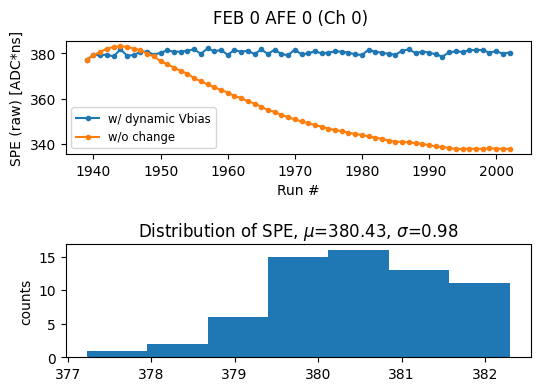

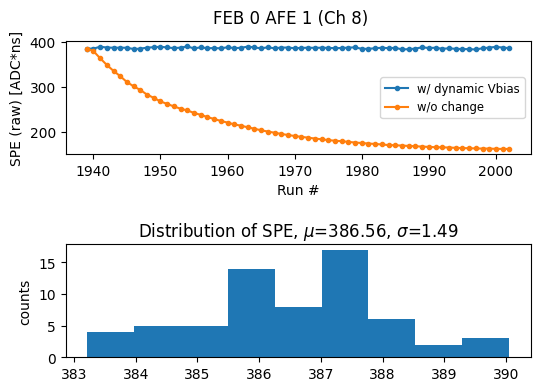

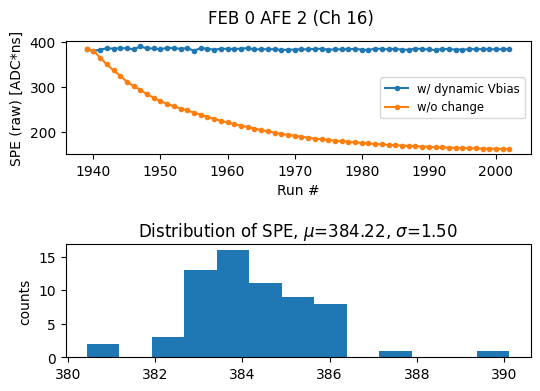

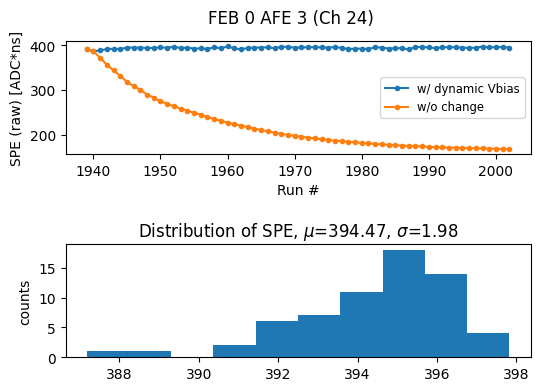

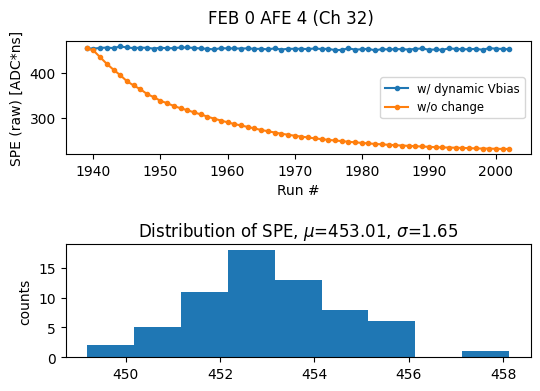

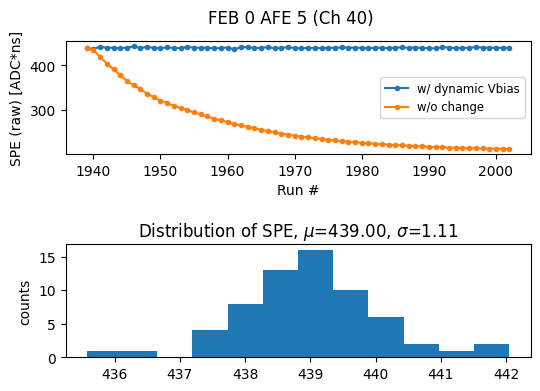

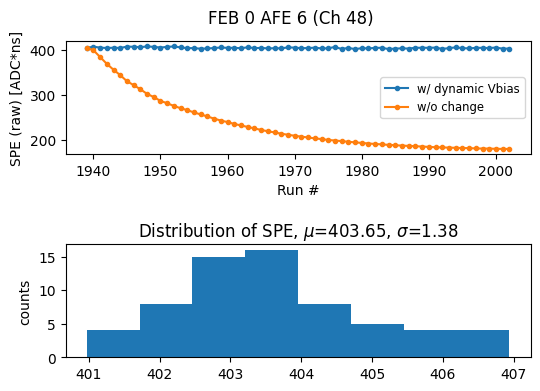

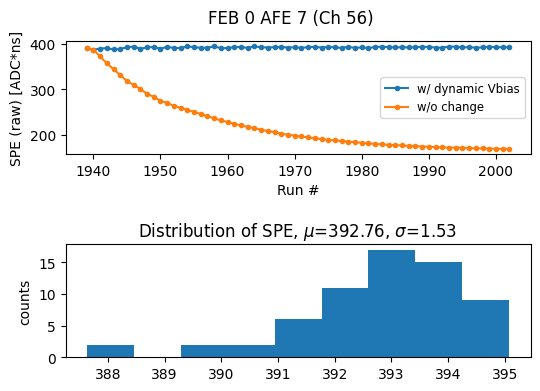

In [12]:
for iAFE in range(8):
    fig = plt.figure(figsize = (6,4))
    fig.subplots_adjust(top=0.9)
    plt.suptitle('FEB 0 AFE %i (Ch %i)'%(iAFE, iAFE*8))
    axs = fig.subplots(2, 1, #sharex='col',
                       gridspec_kw={'height_ratios':[4,4],
                                    'wspace':0, 'hspace':0.8})
    ytitles = ['SPE (raw) [ADC*ns]', 'counts']
    for ii in range(2):
        axs[ii].set_ylabel(ytitles[ii])
    axs[0].set_xlabel('Run #')

    df_run_ = df_runs.query("ch==%i"%(8*iAFE)).reset_index()

    axs[0].plot(df_run_['run'], df_run_['calibRaw'],'.-', label='w/ dynamic Vbias')
    temp_shifted = np.add((df_run_['CMBtemp']-df_run_['CMBtemp'][0])*(-55.4), (df_run_['FEBtemp']-df_run_['FEBtemp'][0])*(4.09)) * 0.1255
    temp_shifted = np.add(temp_shifted, (df_run_['FEBtemp']-df_run_['FEBtemp'][0])*(-1.46)) + df_run_['calibRaw'][0]
    axs[0].plot(df_run_['run'], temp_shifted,'.-', label='w/o change')
    axs[0].legend(fontsize='small')
    
    #axs[1].plot(df_run_['run'], df_run_['PEs'],'.-', label='w/ dynamic Vbias')
    #axs[1].legend(fontsize='small')
    
    axs[1].hist(df_run_['calibRaw'], bins='auto')
    axs[1].set_title("Distribution of SPE, "+r'$\mu$'+"=%.2f"%(np.mean(df_run_['calibRaw']))+r', $\sigma$'+"=%.2f"%(np.std(df_run_['calibRaw'])))


    plt.show()

Pulser seemed not turned on... all PEs = 0.